In [1]:
import torch
import numpy as np
import os
from kvae_model import KVAEModel
from tqdm import tqdm
import pickle

from kvae import KVAE, load_bouncing_ball, export_vid
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
batch_size = 64
train_dataset, val_dataset =  load_bouncing_ball("nonlinear_ball_data", "circlelong", singular=False)
#train_dataset = train_dataset[np.random.choice(5000, 2560)]
#val_dataset = val_dataset[np.random.choice(1000, 512)]
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers = 0)
val_dataloader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle = True, num_workers = 0)

In [3]:
model = KVAEModel(x_dim = 32 * 32, 
            a_dim = 4,
            z_dim = 4, 
            x_2d=True,
            init_kf_mat = 0.05,
            noise_transition = 0.08,
            noise_emission = 0.03,
            init_cov = 20,
            K = 1,
            dim_RNN_alpha = 50,
            num_RNN_alpha = 2,
            dropout_p = 0,
            scale_reconstruction = 0.3,
            device='cpu').to('cpu')
model.build()

kvae = KVAE(model=model,
            lr = 3e-3,#3e-6,
            lr_tot = 1e-3,#1e-6,
            epochs = 20,
            batch_size = batch_size,
            early_stop_patience = 20,
            save_frequency = 1,
            only_vae_epochs = 5,
            kf_update_epochs = 5,
            save_dir = "results")

In [18]:
kvae.model.load_state_dict(torch.load("results/t25_circle_IS_G_a4/model_at_93.pt", map_location='cpu'))

<All keys matched successfully>

In [19]:
export_vid(kvae, train_dataloader, j=0, both=True, epoch=555)

torch.Size([64, 32, 32, 200]) (64, 32, 32, 200)


In [20]:
t = torch.Tensor(train_dataloader.dataset[0:0+64])
kvae.model.eval()
with torch.no_grad():
    x, y, a, a_gen, mu_smooth = kvae.model.forward_debug(t, compute_loss=False)

In [6]:
kvae.generate(torch.tensor(mu_smooth, requires_grad=False), n_steps=20)

RuntimeError: The size of tensor a (64) must match the size of tensor b (20) at non-singleton dimension 0

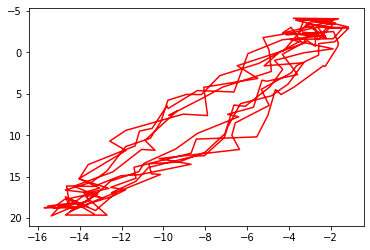

In [21]:
plt.plot(mu_smooth[:, 0, 0], mu_smooth[:, 0, 1], "r-")
plt.gca().invert_yaxis()

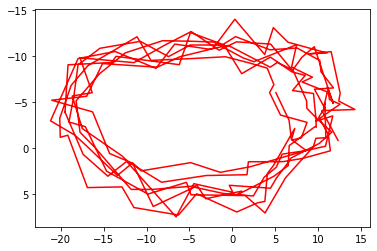

In [10]:
plt.plot(a[:, 0, 2], a[:, 0, 3], "r-")
plt.gca().invert_yaxis()

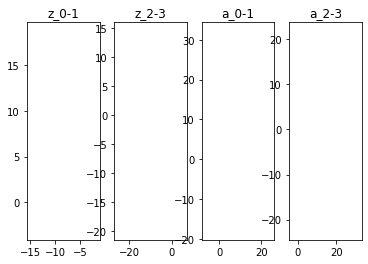

In [22]:
from matplotlib.animation import FuncAnimation
xs = [mu_smooth[:, 0, 0], mu_smooth[:, 0, 2], a[:, 0, 0], a[:, 0, 2]]
ys = [mu_smooth[:, 0, 1], mu_smooth[:, 0, 3], a[:, 0, 1], a[:, 0, 3]]
titles = ["z_0-1", "z_2-3", "a_0-1", "a_2-3"]
fig, axs = plt.subplots(nrows=1, ncols=4)#, figsize=(5, 3))
lines = []
for j in range(4):
    axs[j].set(xlim=(xs[j].min(), xs[j].max()), ylim=(ys[j].min(), ys[j].max()), title=titles[j])
    lines.append(axs[j].plot(xs[j][0], ys[j][0], color='k', lw=2)[0])
def animate(i):
    for j in range(4):
        lines[j].set_data(xs[j][:i], ys[j][:i])
anim = FuncAnimation(
    fig, animate, interval=50, frames=200-1)
anim.save('results/z_circle.mp4')

In [22]:
alpha = kvae.model.a_to_alpha(torch.tensor(a, requires_grad=False))

In [10]:
print(x.shape, y.shape, a.shape, a_gen.shape, mu_smooth.shape, alpha.shape)

(20, 64, 1024) (64, 1024, 20) (20, 64, 2) (20, 64, 2) (20, 64, 4) torch.Size([20, 64, 3])


In [20]:
alpha

tensor([[[0.2321, 0.4276, 0.3404],
         [0.2321, 0.4276, 0.3404],
         [0.2321, 0.4276, 0.3404],
         ...,
         [0.2321, 0.4276, 0.3404],
         [0.2321, 0.4276, 0.3404],
         [0.2321, 0.4276, 0.3404]],

        [[0.1488, 0.3936, 0.4576],
         [0.3469, 0.4027, 0.2504],
         [0.1738, 0.3632, 0.4631],
         ...,
         [0.3547, 0.3965, 0.2489],
         [0.1823, 0.3593, 0.4584],
         [0.1649, 0.3749, 0.4602]],

        [[0.1315, 0.2732, 0.5953],
         [0.4782, 0.3434, 0.1784],
         [0.1407, 0.2417, 0.6176],
         ...,
         [0.4627, 0.3672, 0.1700],
         [0.1408, 0.2541, 0.6050],
         [0.1345, 0.2474, 0.6181]],

        ...,

        [[0.0068, 0.6245, 0.3687],
         [0.3270, 0.5301, 0.1429],
         [0.6906, 0.2093, 0.1000],
         ...,
         [0.2736, 0.3988, 0.3276],
         [0.4734, 0.4272, 0.0994],
         [0.7378, 0.2129, 0.0493]],

        [[0.0202, 0.4005, 0.5793],
         [0.4120, 0.4743, 0.1137],
         [0.

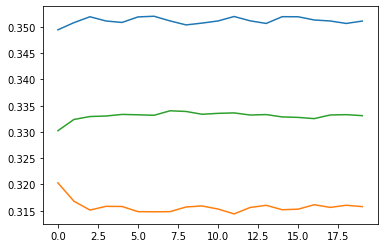

In [23]:
for i in range(3):
    plt.plot(alpha[:, 3, i])

In [20]:
for pr in kvae.model.named_parameters():
    print(pr[1].grad)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [29]:
p = test[1].detach().numpy()

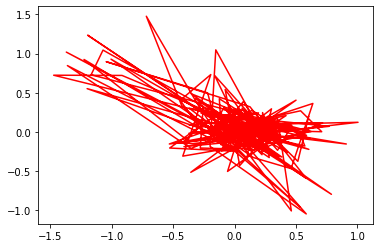

In [31]:
plt.plot(p[:, 0], p[:, 1], 'r-')

In [55]:
a = torch.tensor(a, requires_grad=False).detach()

In [56]:
seq_len = a.shape[0]
batch_size = a.shape[1]
u_0 = torch.zeros(1, batch_size, kvae.model.u_dim).to("cpu")
u = torch.cat((u_0, a[:-1]), 0)
K = kvae.model.K; A = kvae.model.A; B = kvae.model.B; C = kvae.model.C; R = kvae.model.R; Q = kvae.model.Q
optimal_gain=False; alpha_sq=1

In [57]:
kvae.model.mu = torch.zeros((batch_size, kvae.model.z_dim)).to(kvae.model.device) # (bs, z_dim), z_0
kvae.model.Sigma = kvae.model.init_cov * torch.eye(kvae.model.z_dim).unsqueeze(0).repeat(batch_size, 1, 1).to(kvae.model.device) # (bs, z_dim, z_dim), Sigma_0
mu_pred = torch.zeros((seq_len, batch_size, kvae.model.z_dim)).to(kvae.model.device) # (seq_len, bs, z_dim)
mu_filter = torch.zeros((seq_len, batch_size, kvae.model.z_dim)).to(kvae.model.device) # (seq_len, bs, z_dim)
mu_smooth = torch.zeros((seq_len, batch_size, kvae.model.z_dim)).to(kvae.model.device) # (seq_len, bs, z_dim)
Sigma_pred = torch.zeros((seq_len, batch_size, kvae.model.z_dim, kvae.model.z_dim)).to(kvae.model.device) # (seq_len, bs, z_dim, z_dim)
Sigma_filter = torch.zeros((seq_len, batch_size, kvae.model.z_dim, kvae.model.z_dim)).to(kvae.model.device) # (seq_len, bs, z_dim, z_dim)
Sigma_smooth = torch.zeros((seq_len, batch_size, kvae.model.z_dim, kvae.model.z_dim)).to(kvae.model.device) # (seq_len, bs, z_dim, z_dim)

In [58]:
# Calculate the mixture of A, B and C
A_flatten = A.view(K, kvae.model.z_dim*kvae.model.z_dim) # (K, z_dim*z_dim) 
B_flatten = B.view(K, kvae.model.z_dim*kvae.model.u_dim) # (K, z_dim*u_dim) 
C_flatten = C.view(K, kvae.model.a_dim*kvae.model.z_dim) # (K, a_dim*z_dim) 
A_mix = alpha.matmul(A_flatten).view(seq_len, batch_size, kvae.model.z_dim, kvae.model.z_dim)
B_mix = alpha.matmul(B_flatten).view(seq_len, batch_size, kvae.model.z_dim, kvae.model.u_dim)
C_mix = alpha.matmul(C_flatten).view(seq_len, batch_size, kvae.model.a_dim, kvae.model.z_dim)

In [59]:
A_mix.shape

torch.Size([20, 7, 4, 4])

In [62]:
# Forward filter
for t in range(seq_len):

    # Mixture of A, B and C
    A_t = A_mix[t] # (bs, z_dim. z_dim)
    B_t = B_mix[t] # (bs, z_dim, u_dim)
    C_t = C_mix[t] # (bs, a_dim, z_dim)

    if t == 0:
        mu_t_pred = kvae.model.mu.unsqueeze(-1) # (bs, z_dim, 1)
        Sigma_t_pred = kvae.model.Sigma
    else:
        u_t = u[t,:,:] # (bs, u_dim)
        mu_t_pred = A_t.bmm(mu_t) + B_t.bmm(u_t.unsqueeze(-1)) # (bs, z_dim, 1), z_{t|t-1}
        Sigma_t_pred = alpha_sq * A_t.bmm(Sigma_t).bmm(A_t.transpose(1,2)) + Q # (bs, z_dim, z_dim), Sigma_{t|t-1}
        # alpha_sq (>=1) is fading memory control, which indicates how much you want to forgert past measurements, see more infos in 'FilterPy' library

    # Residual
    a_pred = C_t.bmm(mu_t_pred)  # (bs, a_dim, z_dim) x (bs, z_dim, 1)
    res_t = a[t, :, :].unsqueeze(-1) - a_pred # (bs, a_dim, 1)

    # Kalman gain
    S_t = C_t.bmm(Sigma_t_pred).bmm(C_t.transpose(1,2)) + R # (bs, a_dim, a_dim)
    S_t_inv = S_t.inverse()
    K_t = Sigma_t_pred.bmm(C_t.transpose(1,2)).bmm(S_t_inv) # (bs, z_dim, a_dim)

    # Update 
    mu_t = mu_t_pred + K_t.bmm(res_t) # (bs, z_dim, 1)
    I_KC = kvae.model._I - K_t.bmm(C_t) # (bs, z_dim, z_dim)
    if optimal_gain:
        Sigma_t = I_KC.bmm(Sigma_t_pred) # (bs, z_dim, z_dim), only valid with optimal Kalman gain
    else:
        Sigma_t = I_KC.bmm(Sigma_t_pred).bmm(I_KC.transpose(1,2)) + K_t.matmul(R).matmul(K_t.transpose(1,2)) # (bs, z_dim, z_dim), general case
    # Save cache
    mu_pred[t] = mu_t_pred.view(batch_size, kvae.model.z_dim)
    mu_filter[t] = mu_t.squeeze()
    Sigma_pred[t] = Sigma_t_pred
    Sigma_filter[t] = Sigma_t

In [63]:
# Add the final state from filter to the smoother as initialization
mu_smooth[-1] =  mu_filter[-1]
Sigma_smooth[-1] = Sigma_filter[-1]

In [64]:
# Backward smooth, reverse loop from pernultimate state
for t in range(seq_len-2, -1, -1):

    # Backward Kalman gain
    J_t = Sigma_filter[t].bmm(A_mix[t+1].transpose(1,2)).bmm(Sigma_pred[t+1].inverse()) # (bs, z_dim, z_dim)

    # Backward smoothing
    dif_mu_tp1 = (mu_smooth[t+1] - mu_filter[t+1]).unsqueeze(-1) # (bs, z_dim, 1)
    mu_smooth[t] = mu_filter[t] + J_t.matmul(dif_mu_tp1).view(batch_size, kvae.model.z_dim) # (bs, z_dim)
    dif_Sigma_tp1 = Sigma_smooth[t+1] - Sigma_pred[t+1] # (bs, z_dim, z_dim)
    Sigma_smooth[t] = Sigma_filter[t] + J_t.bmm(dif_Sigma_tp1).bmm(J_t.transpose(1,2)) # (bs, z_dim, z_dim)

In [ ]:
# Generate a from smoothing z
a_gen = C_mix.matmul(mu_smooth.unsqueeze(-1)).view(seq_len, batch_size, self.a_dim) # (seq_len, bs, a_dim)
def debug(n, v):
    print(n, v.shape, "Nan:", torch.isnan(v).any(),"inf:", torch.isinf(v).any(), v)
if torch.isnan(Sigma_smooth).any():
    #print("Sigma", Sigma_smooth.shape, Sigma_smooth)
    #print("latest j", J_t)
    #print("latest sigma_pred", Sigma_pred)
    #print("latest")
    #print("A_flatten", A_flatten)
    #print("a_init", self.a_init)
    #print("a_init_expand", a_init_expand)
    #print("a_tm1", a_tm1)
    #print("alpha", alpha)
    #debug("a", a)
    #debug("a_init", self.a_init)
    #debug("a_init_expand", a_init_expand)
    #debug("a_tm1", a_tm1)
    #debug("alpha", alpha)
    pass

return a_gen, mu_smooth, Sigma_smooth, A_mix, B_mix, C_mix

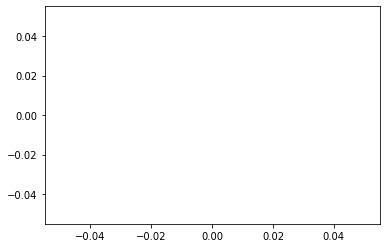

In [11]:
plt.plot(a_gen[:, 0, 0], a_gen[:, 0, 1], "r-")

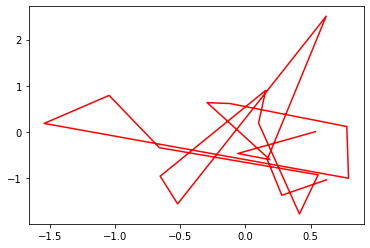

In [12]:
plt.plot(a[:, 0, 0], a[:, 0, 1], "r-")

In [1]:
import torch

In [4]:
test = torch.load("results/model_at_2.pt")

In [7]:
test["C"]

tensor([[[ 0.0226, -0.0165,  0.0201,  ...,  0.1372,  0.0254, -0.0083],
         [ 0.0086, -0.0140, -0.0469,  ...,  0.0540, -0.0763, -0.0340],
         [-0.0502,  0.0270, -0.0722,  ..., -0.0148, -0.0126,  0.0316],
         ...,
         [-0.0284, -0.0158,  0.0303,  ...,  0.0269,  0.0420, -0.0524],
         [ 0.0361, -0.0289,  0.0586,  ..., -0.1141, -0.0663, -0.0138],
         [ 0.0173, -0.0603,  0.0420,  ..., -0.0271,  0.0053, -0.0478]],

        [[ 0.0264,  0.0941,  0.0219,  ..., -0.0542, -0.0285,  0.0581],
         [ 0.0263, -0.0916, -0.0068,  ...,  0.0480, -0.0175,  0.0423],
         [-0.0165, -0.0270,  0.0002,  ...,  0.0756, -0.0388, -0.0818],
         ...,
         [ 0.0392, -0.0314, -0.0731,  ..., -0.0082, -0.0745, -0.0060],
         [-0.0409, -0.0194, -0.0407,  ...,  0.0507,  0.0205, -0.0193],
         [ 0.0248, -0.0469, -0.0942,  ..., -0.0317,  0.0576, -0.0322]],

        [[-0.0627,  0.0172,  0.0487,  ...,  0.0248, -0.1353,  0.0250],
         [-0.0274, -0.0585,  0.0045,  ..., -0